In [1]:
import menpo3d.io as m3dio
import menpo.io as mio
import menpo3d
import numpy as np
import mappings

from io import BytesIO
from scipy.io import loadmat, savemat
from functools import reduce
from pathlib import Path

from menpo.image import Image, MaskedImage
from menpo.transform import AlignmentSimilarity
from menpo.shape import PointCloud, TriMesh, ColouredTriMesh, TexturedTriMesh
from menpo.visualize import print_progress

np.set_printoptions(precision=3, suppress=True)

In [2]:
root_dir = Path('/data/ICT3D/expressions/')

In [3]:
paths = list(root_dir.glob('**/diff_normal_b*.bmp'))

In [4]:
from menpofit.aam import load_balanced_frontal_face_fitter
from menpodetect.dlib import load_dlib_frontal_face_detector

In [5]:
detector = load_dlib_frontal_face_detector()
aam = load_balanced_frontal_face_fitter()

In [15]:
def get_normals(path):
    nrm = mio.import_image(path)
    texture_path = Path(str(path).replace('normal_b', 'texture'))
    im = mio.import_image(texture_path)
    im = im.rescale_to_diagonal(600)
    nrm = nrm.rescale_to_diagonal(600)
    
    bb = detector(im, image_diagonal=300)[0]
    rescaled_im, transform = im.rescale_to_diagonal(300, return_transform=True)
    nrm.landmarks['PTS'] = transform.apply(
        aam.fit_from_bb(rescaled_im, transform.pseudoinverse().apply(bb), ).final_shape)
    nrm = nrm.as_masked().constrain_mask_to_landmarks()
    
    mask = nrm.mask.pixels[0]
    
    
    nrm.pixels[:, ~mask] = -1
    im = im.as_masked()
    im.mask =  nrm.mask
    return im, nrm

In [16]:
im, nrm = get_normals(paths[0])

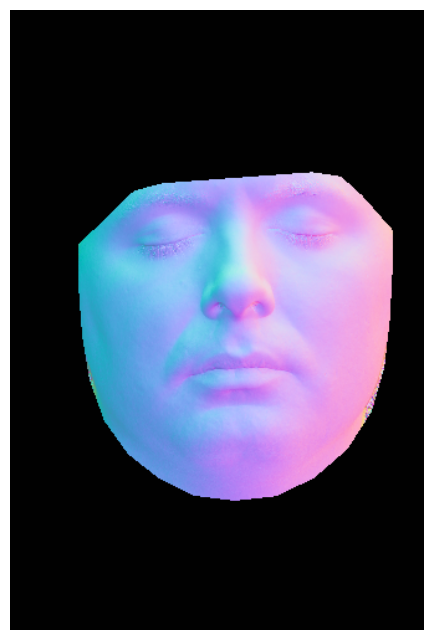

In [17]:
%matplotlib inline

nrm.view()

In [68]:
diff = mio.import_image(list(root_dir.glob('**/diff_textu*.bmp'))[0])


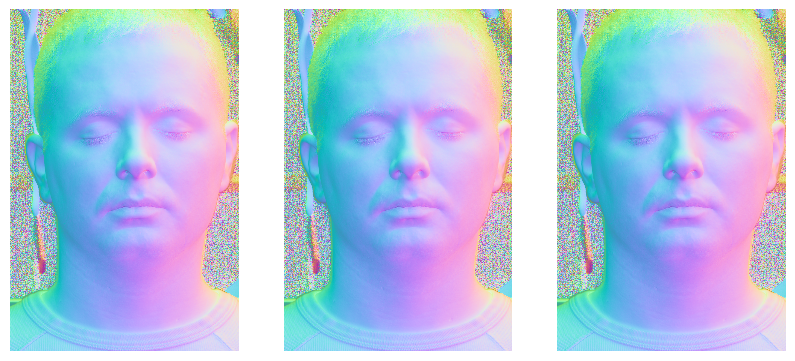

In [61]:
%matplotlib inline
plt.figure()
plt.subplot(131)
nrm_b = mio.import_image(list(root_dir.glob('**/diff_normal_b*.bmp'))[0])
nrm.view()

plt.subplot(132)
nrm_r = mio.import_image(list(root_dir.glob('**/diff_normal_r*.bmp'))[0])
nrm.view()

plt.subplot(133)
nrm_g = mio.import_image(list(root_dir.glob('**/diff_normal_g*.bmp'))[0])
nrm.view()

In [18]:
def crop_face(img, boundary=30, group=None, shape=(386, 386), order=1):
    min_indices, max_indices = img.mask.bounds_true(boundary=boundary)
    h = max_indices[0] - min_indices[0]
    w = max_indices[1] - min_indices[1]
    pad = abs(w - h)

    try:
        index = 1 - int(w > h)
        min_indices[index] -= int(pad / 2.)
        max_indices[index] += int(pad / 2.) + int(pad) % 2

        img = img.crop(min_indices, max_indices, constrain_to_boundary=True)
    except Exception as e:
        print("Exception in crop_face", e)

    img = img.resize(shape, order=order)
    return img

In [21]:
def _int_feauture(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feauture(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def get_jpg_string(im):
    '''Serializes an `Image` to bytes.'''
    fp = BytesIO()
    mio.export_image(im, fp, extension='jpg')
    fp.seek(0)
    return fp.read()

def serialize_sample(image, normals):
    height, width = image.shape
    
    example = tf.train.Example(features=tf.train.Features(feature={
                'height': _int_feauture(height),
                'width': _int_feauture(width),
                'image': _bytes_feauture(get_jpg_string(image)),
                'normals': _bytes_feauture(normals.pixels_with_channels_at_back().astype(np.float32).tobytes())
    }))
    
    return example

In [22]:
import tensorflow as tf

In [35]:
!du -hs /vol/atlas/databases/tf_records/ict_386x386.tfrecords

318M	/vol/atlas/databases/tf_records/ict_386x386.tfrecords


In [30]:
path = '/vol/atlas/databases/tf_records/ict_386x386.tfrecords'
writer = tf.python_io.TFRecordWriter(path)

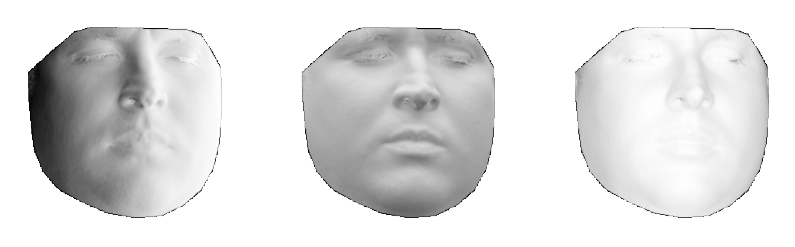

In [31]:
nrm.view(channels='all')

In [32]:
paths = list(root_dir.glob('**/diff_normal_b*.bmp'))

for path in print_progress(paths):
    try:
        im, nrm = get_normals(path)
        image = crop_face(im)
        nrm = crop_face(nrm)
    
        example = serialize_sample(image.as_unmasked(), nrm)
        writer.write(example.SerializeToString())
    except:
        pass

writer.close()

[=================== ] 98% (341/345) - 00:00:07 remaining                       

IndexError: list index out of range